In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge #使用核技巧的岭回归
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# 离群点处理

In [3]:
rm_id = df_train.sort_values(by='GrLivArea',ascending=False)[:2].index
df_train = df_train.drop(rm_id)
print df_train.shape

(1458, 81)


In [4]:
df_train_m = df_train.shape[0]

In [5]:
df_train.isnull().sum().sort_values(ascending=False)[:20]

PoolQC          1452
MiscFeature     1404
Alley           1367
Fence           1177
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

In [6]:
df_test.isnull().sum().sort_values(ascending=False)[:20]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64

In [7]:
print(df_train.shape)
print(df_test.shape)

(1458, 81)
(1459, 80)


In [8]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
df_train_y = df_train['SalePrice']
y_train = df_train['SalePrice']

In [10]:
df_test_id = df_test['Id']

In [11]:
df_train.drop(['SalePrice'],inplace=True,axis=1)

In [12]:
df_data = pd.concat([df_train,df_test],ignore_index=True)

# 特征提取和选择

In [13]:
#把表示地下室面积的特征想加起来，创建一个总地下室面积的类
df_data['TotalSF'] = df_data['TotalBsmtSF']+df_data['1stFlrSF']+df_data['2ndFlrSF']
feat_select = ['TotalSF']

In [14]:
#根据EDA的分析结果，'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars'，’FullBath‘，'TotRmsAbvGrd'跟SalePrice有很强的相关性
# 此处TotalBsmtSF由TotalSF替代
cols = ['OverallQual','GrLivArea','TotalSF', 'GarageCars', 'FullBath','TotRmsAbvGrd']
df_data = df_data[cols]

# 缺失值填充

In [15]:
df_data.isnull().sum()

OverallQual     0
GrLivArea       0
TotalSF         1
GarageCars      1
FullBath        0
TotRmsAbvGrd    0
dtype: int64

In [16]:
df_data['TotalSF'] = df_data['TotalSF'].fillna(0)

In [17]:
df_data['GarageCars'] = df_data['GarageCars'].fillna(0)

# 独热编码

In [18]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 6 columns):
OverallQual     2917 non-null int64
GrLivArea       2917 non-null int64
TotalSF         2917 non-null float64
GarageCars      2917 non-null float64
FullBath        2917 non-null int64
TotRmsAbvGrd    2917 non-null int64
dtypes: float64(2), int64(4)
memory usage: 136.8 KB


# Box Cox转换

In [19]:
#对数值特征进行处理，求出每个数值特征对应的偏度值
numeric_feats = df_data.dtypes[df_data.dtypes!='object'].index
skewed_feats = df_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'skewness':skewed_feats})
skewness.head()

,skewness
GrLivArea,1.068750
TotalSF,0.998560
TotRmsAbvGrd,0.749232
OverallQual,0.189591
FullBath,0.165514


In [20]:
#Box Cox转换，只对skewness值大于0.75的进行处理
skewness = skewness[abs(skewness['skewness']) > 0.75]
print('There are {} skewed numeric features to Box Cox trainsform'.format(skewness.shape))

There are (2, 1) skewed numeric features to Box Cox trainsform


In [21]:
skewed_features = skewness.index
df_data_new = df_data.copy()
lam = 0.15
for feat in skewed_features:
    df_data_new[feat] = boxcox1p(df_data[feat], lam)
df_data_new[skewed_features].head()

,GrLivArea,TotalSF
0,13.698888,14.976591
1,12.792276,14.923100
2,13.832085,15.149678
3,13.711364,14.857121
4,14.480029,15.852312


In [22]:
df_data[skewed_features].head()

,GrLivArea,TotalSF
0,1710,2566.0
1,1262,2524.0
2,1786,2706.0
3,1717,2473.0
4,2198,3343.0


In [23]:
skewed_features

Index([u'GrLivArea', u'TotalSF'], dtype='object')

In [24]:
for feat in skewed_features:
    df_data[feat] = df_data_new[feat]

In [25]:
df_train_y = np.log(df_train_y+1)

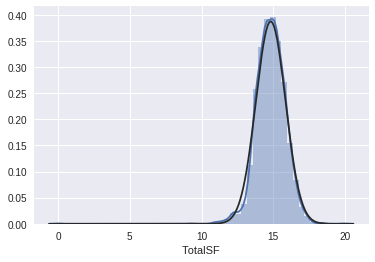

In [26]:
sns.distplot(df_data['TotalSF'], fit=norm)

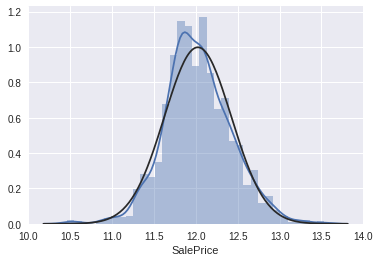

In [27]:
sns.distplot(df_train_y, fit=norm)

# 特征缩放

In [28]:
df_data.describe()

,OverallQual,GrLivArea,TotalSF,GarageCars,FullBath,TotRmsAbvGrd
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,6.086390,13.167124,14.814868,1.765513,1.567364,6.448063
std,1.406704,0.961384,1.030241,0.762102,0.552465,1.564281
min,1.000000,9.279836,0.000000,0.000000,0.000000,2.000000
25%,5.000000,12.462556,14.182841,1.000000,1.000000,5.000000
50%,6.000000,13.189203,14.824355,2.000000,2.000000,6.000000
75%,7.000000,13.757329,15.478615,2.000000,2.000000,7.000000
max,10.000000,17.321284,19.949240,5.000000,4.000000,15.000000


In [29]:
df_data = StandardScaler().fit_transform(df_data)

In [30]:
df_data = pd.DataFrame(df_data)

# 分开训练集和测试集

In [31]:
df_train = df_data.loc[:df_train_m-1,:]
df_test = df_data.loc[df_train_m:,:].reset_index(drop=True)

In [32]:
df_train.shape

(1458, 6)

In [33]:
df_test.shape

(1459, 6)

# 建立模型

In [34]:
n_folds = 5
#函数功能是使用指定的模型对数据集进行交叉验证，输出交叉验证的均方误差分数
def rmsle_cv(model):
    #使用K折交叉验证
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    #均方误差
    rmse = np.sqrt(-cross_val_score(model, df_train.values, df_train_y, scoring='neg_mean_squared_error', cv=kf))

    return(rmse)

## 基本的模型
**Lasso 回归。这个模型对离群点很敏感，所以我们需要使用skleanr.Robustscaler来提高模型的鲁棒性**

In [35]:
pipe_lasso = Pipeline([('rs1',RobustScaler()), ('lasso',Lasso(alpha=0.0005, random_state=1))])

**弹性网络回归**

In [36]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

**核技巧岭回归**

In [37]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

**Gradient Boosting Regressor**

In [38]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', 
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=5)

**XGBoost**

In [39]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571, 
                             subsample=0.5213, silent=1, nthread=-1)

**LightGBM**

In [40]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=720,
                             max_bin = 55, bagging_fraction=0.8, bagging_freg=5, feature_fraction=0.2319,
                             feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

### 使用交叉验证的方式，算出上面几种基础算法的均方误差，并进行比较

In [41]:
score = rmsle_cv(pipe_lasso)
print('Lasso Score is {:.4f}\{:.4f}'.format(score.mean(), score.std()))

Lasso Score is 0.1662\0.0047


In [42]:
score = rmsle_cv(ENet)
print('ElasticNet Score is {:.4f}\{:.4f}'.format(score.mean(), score.std()))

ElasticNet Score is 0.1662\0.0047


In [43]:
score = rmsle_cv(KRR)
print('Kernel Ridge Score is {:.4f}\{:.4f}'.format(score.mean(), score.std()))

Kernel Ridge Score is 0.1630\0.0039


In [44]:
score = rmsle_cv(GBoost)
print('Gradient Boosting Score is {:.4f}\{:.4f}'.format(score.mean(), score.std()))

Gradient Boosting Score is 0.1725\0.0043


In [45]:
score = rmsle_cv(model_xgb)
print('XGBoosting Score is {:.4f}\{:.4f}'.format(score.mean(), score.std()))

XGBoosting Score is 0.1652\0.0046


In [46]:
score = rmsle_cv(model_lgb)
print('LightGBM Score is {:.4f}\{:.4f}'.format(score.mean(), score.std()))

LightGBM Score is 0.1682\0.0036


## 模型融合
最简单的模型融合方法就是取所有基础模型的均值 <br>
我们通过创建一个类来扩展sklearn，实现符合我们需求的模型融合类

In [47]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [48]:
averaged_models = AveragingModels(models=(pipe_lasso, ENet, GBoost, KRR))
score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1613 (0.0045)



In [49]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [50]:
averaged_models.fit(df_train.values, df_train_y)
stacked_train_pred = averaged_models.predict(df_train.values)
stacked_pred = np.expm1(averaged_models.predict(df_test.values))
print(rmsle(df_train_y, stacked_train_pred))

0.14344892708


In [51]:
model_xgb.fit(df_train, df_train_y)
xgb_train_pred = model_xgb.predict(df_train)
xgb_pred = np.expm1(model_xgb.predict(df_test))
print(rmsle(df_train_y, xgb_train_pred))

0.134564373387


In [58]:
model_lgb.fit(df_train, df_train_y)
lgb_train_pred = model_lgb.predict(df_train)
lgb_pred = np.expm1(model_lgb.predict(df_test))
print(rmsle(df_train_y, lgb_train_pred))

0.156875617804


In [59]:
sub = pd.DataFrame()
sub['Id'] = df_test_id
sub['SalePrice'] = xgb_pred
sub.to_csv('data/xgb_submission.csv',index=False)

In [61]:
sub = pd.DataFrame()
sub['Id'] = df_test_id
sub['SalePrice'] = stacked_pred
sub.to_csv('data/stacked_submission.csv',index=False)

In [62]:
sub = pd.DataFrame()
sub['Id'] = df_test_id
sub['SalePrice'] = lgb_pred
sub.to_csv('data/lgb_submission.csv',index=False)

# 模型调参

#使用网格搜索就gbm参数调优
est = GradientBoostingRegressor()
param_grid = [{'n_estimators':[1000,2000,3000],
              'learning_rate':[0.1,0.01,0.05],
               'min_samples_leaf':[3,6,15],
              'min_samples_split':[7,14,15]}]
est = GridSearchCV(estimator=est,param_grid=param_grid,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)

In [76]:
est = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=4, max_features='sqrt', 
                                   min_samples_leaf=20, min_samples_split=20, loss='huber', random_state=5)

In [77]:
est = est.fit(df_train, df_train_y)

est.best_params_

In [79]:
xgb_pred = np.expm1(est.predict(df_test))

In [80]:
sub = pd.DataFrame()
sub['Id'] = df_test_id
sub['SalePrice'] = xgb_pred
sub.to_csv('data/gbm_submission.csv',index=False)